## Домашнее задание

### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data = brent_data.sort_index()

In [4]:
brent_data.shape

(2667, 11)

Вычисляем первые разности стоимости нефти

In [5]:
brent_data['diff_1'] = (brent_data['Значение'] - brent_data['Значение'].shift(1)).fillna(0)

In [6]:
d_brent_data = brent_data['Значение'].values[1:] - brent_data['Значение'].values[:-1]

### 2. Добавьте первые разности по стоимости доллара и евро к рублю

Считываем курсы валют из внешних источников

In [7]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [8]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


Выведем стоимость нефти и курсы валют на одном графике

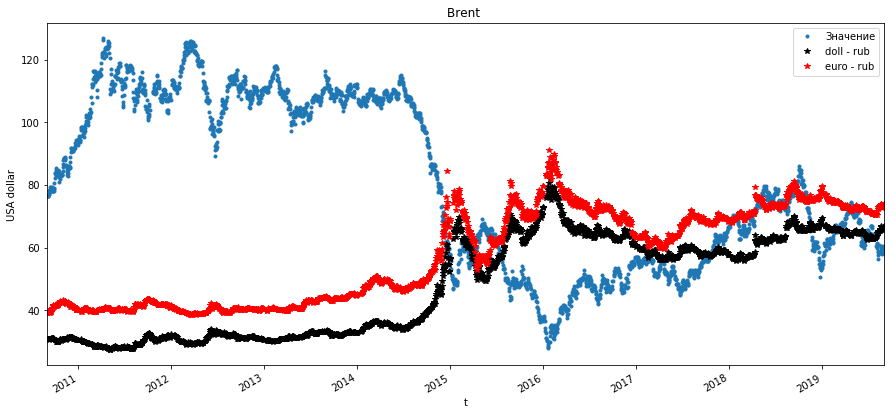

In [9]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Выведем производные стоимости нефти и курсов валют на одном графике

In [10]:
s_brent = np.std(d_brent_data)**0.5*3

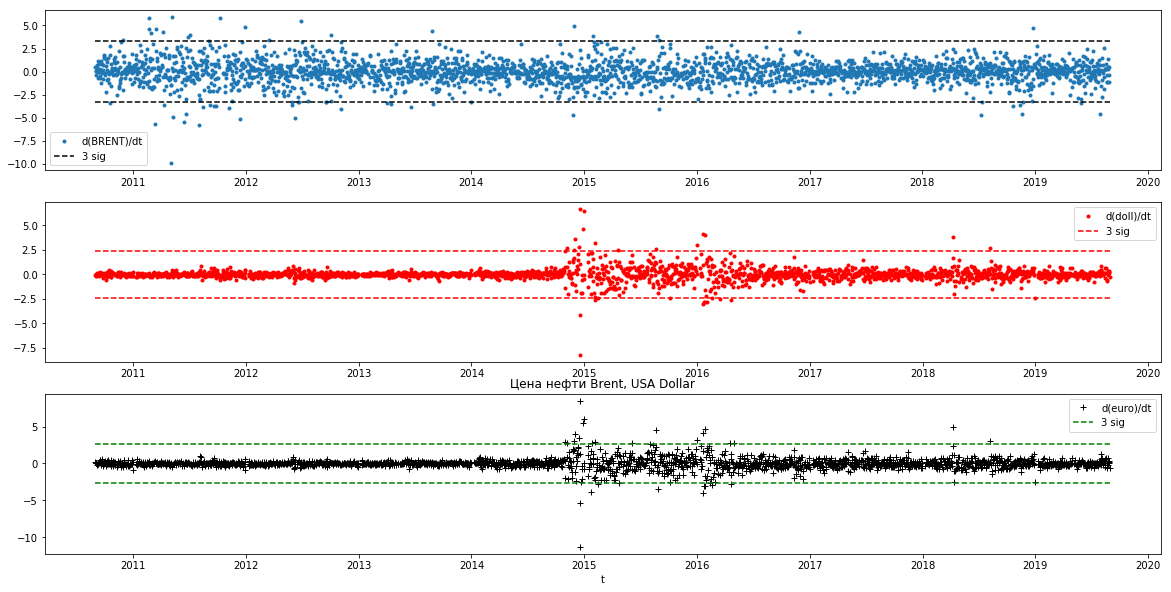

In [11]:
d_rub_doll = rub_doll['curs'].values[1:] - rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:] - rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

Добавим курсы валют в таблицу

In [12]:
brent_data['rub_doll'] = rub_doll

In [13]:
brent_data['rub_e'] = rub_e

В новых колонка много NAN, заполним их линейной интерполяцией

In [14]:
brent_data['rub_doll'] = brent_data['rub_doll'].interpolate(method ='linear', limit_direction ='forward') 

In [15]:
brent_data['rub_e'] = brent_data['rub_e'].interpolate(method ='linear', limit_direction ='forward')

Добавим признаки с производными от курсов валют

In [16]:
brent_data['d_rub_doll'] = (brent_data['rub_doll'] - brent_data['rub_doll'].shift(1)).fillna(0)

In [17]:
brent_data['d_rub_e'] = (brent_data['rub_e'] - brent_data['rub_e'].shift(1)).fillna(0)

### 3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [18]:
brent_data_w = brent_data.resample('W').mean()

Удаляем столбцы, которые стали неинформативными после ресемплинга или ошибочно усреднились

In [19]:
brent_data_w.shape

(470, 16)

In [20]:
brent_data_w.drop(columns = ['year','month', 'dayofmonth', 'quarter', 'dayofyear', 'weekofyear',
                            'is_holiday', 'is_prev_holiday', 'is_next_holiday', 'dayofweek'], inplace=True)

In [21]:
brent_data_w.head()

,Значение,diff_1,rub_doll,rub_e,d_rub_doll,d_rub_e
Дата,,,,,,
2010-09-05,76.616000,0.052000,30.739767,39.241940,-0.042613,0.075660
2010-09-12,77.673333,0.288333,30.764261,39.316383,0.039978,-0.033217
2010-09-19,78.693333,-0.021667,30.824650,39.787733,0.019133,0.199983
2010-09-26,78.518333,0.118333,30.985900,40.975428,-0.022633,0.173511
2010-10-03,81.211667,0.791667,30.563028,41.340456,-0.060939,0.030839


Заново сгенерируем признаки на основе индекса

In [22]:
brent_data_w['date'] = brent_data_w.index

Обнаружена строка со множеством NaN

In [23]:
brent_data_w.loc[brent_data_w['Значение'].isnull()]

,Значение,diff_1,rub_doll,rub_e,d_rub_doll,d_rub_e,date
Дата,,,,,,,
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,2011-10-16


In [24]:
brent_data_w['year'] = brent_data_w['date'].dt.year
brent_data_w['month'] = brent_data_w['date'].dt.month
brent_data_w['quarter'] = brent_data_w['date'].dt.quarter
brent_data_w['weekofyear'] = brent_data_w['date'].dt.weekofyear

In [25]:
brent_data_w.drop(columns = ['date'], inplace=True)

In [26]:
brent_data_w.head()

,Значение,diff_1,rub_doll,rub_e,d_rub_doll,d_rub_e,year,month,quarter,weekofyear
Дата,,,,,,,,,,
2010-09-05,76.616000,0.052000,30.739767,39.241940,-0.042613,0.075660,2010,9,3,35
2010-09-12,77.673333,0.288333,30.764261,39.316383,0.039978,-0.033217,2010,9,3,36
2010-09-19,78.693333,-0.021667,30.824650,39.787733,0.019133,0.199983,2010,9,3,37
2010-09-26,78.518333,0.118333,30.985900,40.975428,-0.022633,0.173511,2010,9,3,38
2010-10-03,81.211667,0.791667,30.563028,41.340456,-0.060939,0.030839,2010,10,4,39


### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
p = 3

#добавляем историю длиной р
for i in range(p):
    brent_data_w['t'+str(p-i)]=0.
    brent_data_w['t'+str(p-i)].values[p+1:] = brent_data_w['Значение'].values[i+1:-(p-i)]
for i in range(p):
    brent_data_w['d'+str(p-i)]=0.   
    brent_data_w['d'+str(p-i)].values[p+1:] = brent_data_w['diff_1'].values[i+1:-(p-i)]

In [29]:
brent_data_w.head()

,Значение,diff_1,rub_doll,rub_e,d_rub_doll,d_rub_e,year,month,quarter,weekofyear,t3,t2,t1,d3,d2,d1
Дата,,,,,,,,,,,,,,,,
2010-09-05,76.616000,0.052000,30.739767,39.241940,-0.042613,0.075660,2010,9,3,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-12,77.673333,0.288333,30.764261,39.316383,0.039978,-0.033217,2010,9,3,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-19,78.693333,-0.021667,30.824650,39.787733,0.019133,0.199983,2010,9,3,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-26,78.518333,0.118333,30.985900,40.975428,-0.022633,0.173511,2010,9,3,38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-10-03,81.211667,0.791667,30.563028,41.340456,-0.060939,0.030839,2010,10,4,39,77.673333,78.693333,78.518333,0.288333,-0.021667,0.118333


Удалим строки с неполной информацией

In [30]:
brent_data_w.drop(brent_data_w.index[:4], inplace=True)

Заполняем пропуски в строке с индексом 2011-10-16

In [31]:
brent_data_w = brent_data_w.interpolate(method ='linear', limit_direction ='forward')

Вот в этой строке было много NaNов

In [32]:
brent_data_w.loc['2011-10-16']

Значение       106.616667
diff_1           1.130833
rub_doll        31.790056
rub_e           43.101208
d_rub_doll      -0.120119
d_rub_e         -0.044025
year          2011.000000
month           10.000000
quarter          4.000000
weekofyear      41.000000
t3             107.106667
t2             103.878333
t1             103.476667
d3              -1.223333
d2              -0.481667
d1               0.455000
Name: 2011-10-16 00:00:00, dtype: float64

### Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [34]:
scl_target=StandardScaler() 

h=1
target = brent_data_w["Значение"].values[h:].reshape((brent_data_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(465, 1)

In [35]:
scl_x=StandardScaler() 

X = brent_data_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(465, 16)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [36]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=65200.22,  I=0
F-test=2.30,  I=1
F-test=2868.82,  I=2
F-test=1866.56,  I=3
F-test=0.42,  I=4
F-test=0.26,  I=5
F-test=521.03,  I=6
F-test=0.10,  I=7
F-test=0.16,  I=8
F-test=0.23,  I=9
F-test=10201.92,  I=10
F-test=14492.84,  I=11
F-test=24150.40,  I=12
F-test=2.54,  I=13
F-test=2.64,  I=14
F-test=2.54,  I=15


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 1 , 2, 3, 6, 10, 11, 12. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

#### Одномерные статистики

In [99]:
sfk1 =SelectKBest(f_regression, k=7)
X_new1 =sfk1.fit_transform(X, y.ravel())
X_new1.shape

(465, 7)

In [100]:
column_names = brent_data_w.columns[sfk1.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e', 'year', 't3', 't2', 't1'], dtype='object')

In [101]:
sfk2=SelectKBest(mutual_info_regression, k=7)
X_new2 = sfk2.fit_transform(X, y.ravel())
X_new2.shape

(465, 7)

In [102]:
column_names = brent_data_w.columns[sfk2.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e', 'year', 't3', 't2', 't1'], dtype='object')

#### Отбор на основе модели

In [103]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(465, 3)

In [104]:
column_names = brent_data_w.columns[sfm.get_support()]
column_names

Index(['Значение', 'rub_doll', 'rub_e'], dtype='object')

In [105]:
list_param_k1 =np.where(sfk1.get_support())[0]
list_param_k2 =np.where(sfk2.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k1 лучших : ',list_param_k1)
print('Номера признаков k2 лучших: ',list_param_k2)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k1 лучших :  [ 0  2  3  6 10 11 12]
Номера признаков k2 лучших:  [ 0  2  3  6 10 11 12]
Номера признаков для выбора по модели :  [0 2 3]


In [211]:
par_with_val = [0,2,3,4,5,6,10,11,12]
par_without_val = [0,6,10,11,12]
X_with_val = X[:,par_with_val]
X_without_val = X[:,par_without_val]

Список параметров включая данные по курсам валют

In [212]:
brent_data_w.columns[par_with_val]

Index(['Значение', 'rub_doll', 'rub_e', 'd_rub_doll', 'd_rub_e', 'year', 't3',
       't2', 't1'],
      dtype='object')

Список параметров без данных по курсам валют

In [213]:
brent_data_w.columns[par_without_val]

Index(['Значение', 'year', 't3', 't2', 't1'], dtype='object')

### Разделение данных на тестовые и тренировочные 

In [214]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

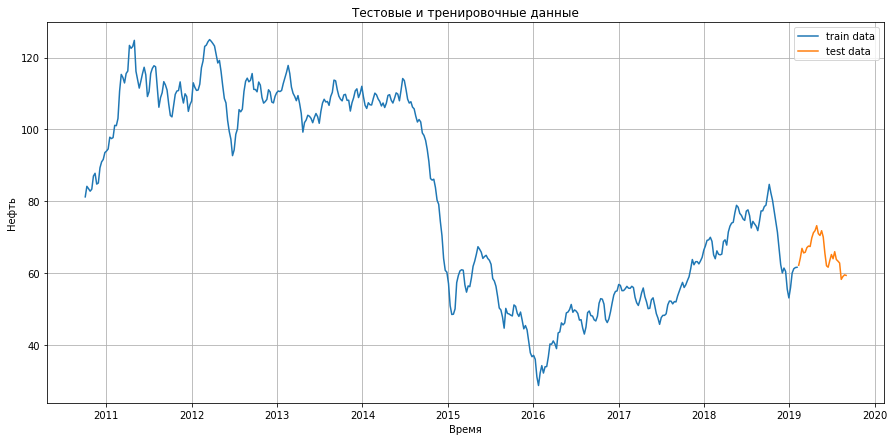

In [215]:
train, test = split_data(brent_data_w, -30)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

Данные с признаками по валюте

In [216]:
X_train_val = X_with_val[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test_val = X_with_val[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

Данные без признаков по валюте

In [217]:
X_train = X_without_val[:train.shape[0],:]
X_test = X_without_val[train.shape[0]:,:]

### Построение модели без признаков по валюте

In [218]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [219]:
from sklearn.ensemble import GradientBoostingRegressor

In [220]:
# from sklearn.model_selection import GridSearchCV

# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")

# #param_dist = {"max_depth": [1, 2, 3], 
# #              "n_estimators":[100, 150, 200, 250, 300]}

# param_dist = {"max_depth": [3], 
#               "n_estimators":[i for i in range(10, 1000, 10)]}


# #  randomized search
# n_iter_search = 10

# model_gr =GradientBoostingRegressor()

# random_search = GridSearchCV(model_gr, param_grid=param_dist, cv=5, iid=False)

# random_search.fit(X_train, y_train)

# report(random_search.cv_results_)

1-960 2-400 3-610

In [221]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=10, n_estimators=400)

In [222]:
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=10, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [223]:
y_pred_g = model_g.predict(X_train)
y_test_pred_g = model_g.predict(X_test)

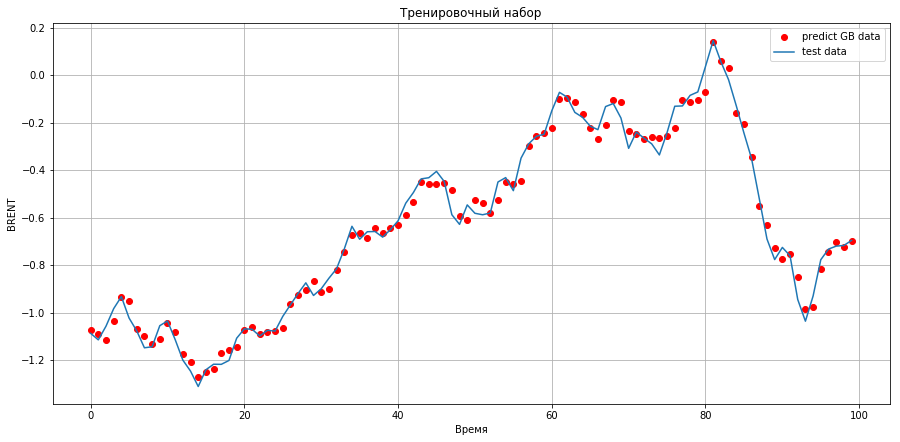

In [224]:
plt.figure( figsize=( 15, 7 ))

plt.title('Тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

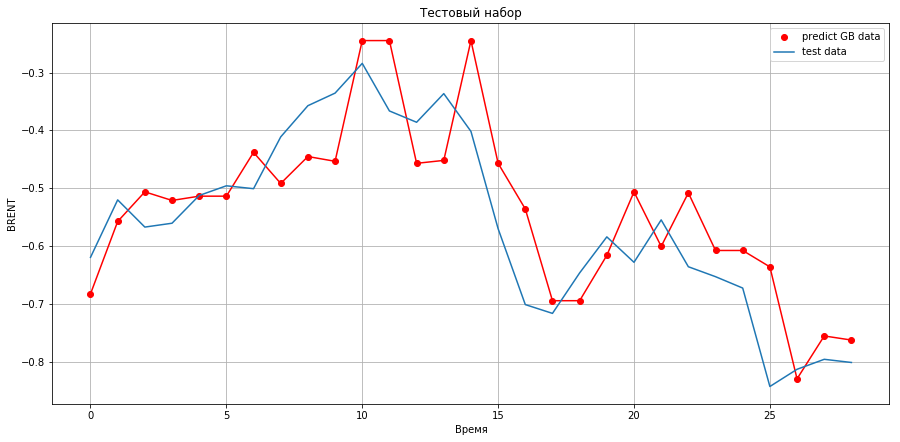

In [225]:
plt.figure( figsize=( 15, 7 ))
plt.title('Тестовый набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g,'or', label='predict GB data' )
plt.plot(y_test_pred_g,'r' )
plt.plot(y_test, label='test data')
plt.grid()
plt.legend()
plt.show()

In [226]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.007995865202569927 
ошибка mae  :   0.07452421637389353 
оценка R2 :   0.6634891783001406


In [227]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.0391014697069973 %


### Построение модели с признаками по валюте

In [229]:
model_g.fit( X_train_val, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=10, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [230]:
y_pred_g = model_g.predict(X_train_val)
y_test_pred_g = model_g.predict(X_test_val)

In [231]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.006597993865484748 
ошибка mae  :   0.06684675023413163 
оценка R2 :   0.7223194387354999


In [232]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   2.702915897544799 %


### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Таким образом MAPE модели при использовании признаков, содержащих информацию о курсах валют, уменьшилась на 10%